# Goal:
Previously, I made tested modeling with bag of words. We stopped with SVM with class weight "balanced" but here, I'll use various models with word2vec.  
I will:
- Create word2vec
- Model with word2vec
    - Random forest
    - SVM
- Words to paragraph with Kmean
    - various models
- Tuning    
    - bagging SGD as final model of choice
    
    
Source: [here](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors)

In [7]:
from sklearn.cross_validation import train_test_split
from gensim.models.word2vec import Word2Vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

## Read the data and preprocess

In [8]:
df_original = pd.read_csv('../../projects/alchemyapi/alchemyapi_python/data/df_clearn_en_alchemy_sentiment.csv').drop('Unnamed: 0', 1)
df2 = df_original[:][:]
df2.tail()

,review_id,review_scores_rating,comments,Sentiment,alchemy_sentiment,alchemy_sentiment_score
132327,24139209,85,Nice host..nice place..\nEverything is perfect...,No_label,no_data,no_data
132328,41693126,85,The host canceled this reservation 4 days befo...,No_label,no_data,no_data
132329,45868146,85,I had an amazing experience visiting San Franc...,1,no_data,no_data
132330,50075207,85,Thanks Gavin for making our a month long stay ...,No_label,no_data,no_data
132331,48755174,100,We had a lovely time staying at Julia and Laur...,1,no_data,no_data


In [9]:
Counter(df2.Sentiment)

Counter({'0': 406, '1': 57864, 'No_label': 74062})

In [10]:
# make score string int float 
def to_float(x): 
    try:
        return float(x)
    except:
        return 'no_data'

df2.alchemy_sentiment_score = df2['alchemy_sentiment_score'].apply(to_float)
# change_val(df.alchemy_sentiment_score[132331])

In [11]:
# make float into 1 for positive sentiment or -1 for negative sentiment
def give_sentiment(x): # 
    try:
        if x == 'no_data':
            return 'no_data'
        elif x > 0.:
            return 1
        elif x < 0.:
            return -1
    except:
        return 'no_data'

df2.alchemy_sentiment = df2['alchemy_sentiment_score'].apply(give_sentiment)
# give_sentiment(df.alchemy_sentiment_score[132331])

## Preprocess for word2vec
- Get rid of punctuation
- But not stop words since the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors
- Fit specific format for gensim -> list of list of words

In [12]:
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Use regular expressions to do a find-and-replace
def preprocessing(x): # x = reviews
    x = str(x)
    x = x.decode("utf8")
    raw_sentences = tokenizer.tokenize(x.strip())
    raw_sentences_list =  [[item] for item in raw_sentences]
    
    def sentence_to_word(sentence_list):
        try:
            x = re.sub("[^a-zA-Z]", " ", sentence_list)
            x = x.lower().split()
            return x
        except:
            if x == float:
                return " "
    sentence_list = []
    return map(sentence_to_word, raw_sentences)
    
df2.comments = df2['comments'].apply(preprocessing)
df2.head()

,review_id,review_scores_rating,comments,Sentiment,alchemy_sentiment,alchemy_sentiment_score
0,10612780,92,"[[great, host], [provided, special, gift, bask...",1,1,0.692647
1,49925683,92,"[[great, host], [met, me, at, apartment], [pla...",1,1,0.646267
2,50537634,92,"[[syeda, hosted, my, parents, for, four, days,...",No_label,1,0.656386
3,51077613,92,"[[i, had, a, great, experience, at, syeda, s, ...",1,1,0.817832
4,52109034,92,"[[great, location], [warm, welcoming, host], [...",No_label,1,0.845319


### Create positive/negative/non-labeled dataframes

In [13]:
pos_df2 = df2[df2['alchemy_sentiment'] == 1]
neg_df2 = df2[df2['alchemy_sentiment'] == -1]
no_label_df2 = df2[df2['alchemy_sentiment'] == 'no_data']
print len(pos_df2),len(neg_df2),len(no_label_df2)

4263 285 127784


In [14]:
len(df2) == len(pos_df2)+len(neg_df2)+len(no_label_df2)

True

### Create positive/negative/non-labeled lists and label (y) list

In [15]:
pos_list2 = list(pos_df2.comments)
neg_list2 = list(neg_df2.comments)
no_label_list2 = list(no_label_df2.comments)
y = np.concatenate((np.ones(len(pos_list2)), -1*np.ones(len(neg_list2))))

### Create test/train sets

In [16]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(np.concatenate((pos_list2, neg_list2)), y, test_size=0.2)
len(x_train2), len(x_test2), len(y_train2), len(y_test2)

(3638, 910, 3638, 910)

### Create sentence_list to train the model

In [17]:
import time
start = time.time() 

sentences_list = []

# positive undersampled df
for sentences in pos_df2.comments:
    sentences_list += [sentence for sentence in sentences]

# negative df    
for sentences in neg_df2.comments:
    sentences_list += [sentence for sentence in sentences]

# unlabeled df
for sentences in no_label_df2.comments:
    sentences_list += [sentence for sentence in sentences]
    
sentences_list

end = time.time()
elapsed = end - start
print elapsed, "seconds."

0.228251934052 seconds.


In [18]:
len(sentences_list)

683334

## Training and Saving Your Model



In [58]:
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    
min_word_count = 40 
num_workers = 4       
context = 10          
downsampling = 1e-3 

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print "Training model..."
model = word2vec.Word2Vec(sentences_list, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

model.init_sims(replace=True)

# save the model for later use
model_name = "w2v_airbnb"
model.save(model_name)

Training model...


#### Play with word2vec model

In [59]:
model.doesnt_match("man woman child kitchen".split())

'kitchen'

- Correctly identify human and a thing

In [60]:
model.doesnt_match("france england germany berlin".split())

'france'

- But since the training data is not too big, it's not perfect. It cannot distinguish between country and state. 

In [61]:
model.most_similar("dirty")

[(u'carpet', 0.766893744468689),
 (u'stains', 0.7667901515960693),
 (u'hairs', 0.7643701434135437),
 (u'filthy', 0.7607296705245972),
 (u'dust', 0.7587553262710571),
 (u'mold', 0.746830940246582),
 (u'damp', 0.7393524646759033),
 (u'carpets', 0.7371965050697327),
 (u'stained', 0.7367100715637207),
 (u'odor', 0.7341662645339966)]

- The similar words with the word "dirty" is shown. The result makes sense given the airbnb datasets.

In [62]:
model.most_similar("host")

[(u'hostess', 0.6681894063949585),
 (u'hosts', 0.6006338596343994),
 (u'accommodating', 0.5249692797660828),
 (u'welcoming', 0.5189435482025146),
 (u'helpful', 0.5037181377410889),
 (u'friendly', 0.5018442273139954),
 (u'kind', 0.4748196005821228),
 (u'responsive', 0.4609931707382202),
 (u'person', 0.45862582325935364),
 (u's', 0.4421626925468445)]

- Again, checking similar words for the word "host" for fun

## Model with word2vec

In [63]:
# Load the model 
from gensim.models import Word2Vec
model = Word2Vec.load("w2v_airbnb")

In [64]:
type(model.syn0)

numpy.ndarray

In [65]:
model.syn0.shape

(5191, 300)

In [66]:
model["great"] #a word is 300 dimentional array

array([  3.27325575e-02,   1.58057231e-02,   1.53511204e-02,
        -3.77453305e-02,  -7.36216158e-02,  -9.07632038e-02,
        -3.76278646e-02,  -4.69886437e-02,  -7.88818076e-02,
        -9.65244845e-02,   7.49596953e-02,   7.01496452e-02,
         6.33186176e-02,  -4.34728824e-02,  -4.39027287e-02,
        -9.50193927e-02,   1.38884429e-02,  -6.64180666e-02,
         2.19139308e-02,  -1.16397515e-02,  -3.42830159e-02,
         1.07752671e-02,  -4.48337644e-02,  -7.12861344e-02,
        -5.81341088e-02,  -4.13178392e-02,   6.49818480e-02,
        -7.62336403e-02,   1.48849012e-02,   1.51611134e-01,
         6.32582558e-03,  -2.07566880e-02,   3.22894529e-02,
         4.36933665e-03,  -1.27948374e-01,   1.98486689e-02,
        -7.28630228e-03,   7.25983083e-02,   1.19170889e-01,
        -1.32438973e-01,   1.88596151e-03,  -9.71205183e-04,
         2.63602305e-02,  -5.80227599e-02,  -4.74498868e-02,
        -6.33718446e-04,  -5.12350984e-02,  -1.44569995e-03,
        -1.37667102e-03,

### Create functions to make feature vector
- Averaging all word vectors 

In [67]:
import numpy as np  

def makeFeatureVec(words, model, num_features):
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.

    # Convert it to a set, for speed 
    index2word_set = set(model.index2word)

    # Loop over each word in the review and, if it is in the model's vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])

    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate the average feature vector for each one and return a 2D numpy array 

    # Initialize a counter
    counter = 0.

    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")

    # Loop through the reviews
    for review in reviews:
        # Print a status message every 1000th review
        if counter%1000. == 0.:
            print "Review %d of %d" % (counter, len(reviews))

        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, \
           num_features)

        # Increment the counter
        counter = counter + 1.
    return reviewFeatureVecs

In [68]:
print x_test2[1]

[[u'maureen', u'was', u'friendly', u'and', u'helpful', u'host', u'very', u'comfortable', u'with', u'pretty', u'private', u'room', u'and', u'clean', u'bathroom', u'and', u'a', u'cute', u'cat'], [u'the', u'location', u'was', u'nice', u'a', u'lot', u'of', u'restaurants', u'nearby', u'easy', u'access', u'to', u'downtown', u'muni', u'bus', u'and', u'to', u'sfo', u'airport', u'by', u'bart'], [u'it', u'was', u'a', u'nice', u'first', u'airbnb', u'experience'], [u'thanks', u'maureen']]


## Convert lists of lists of words to lists of words 

- Making sure if string is utf8
- Delete punctuation and number
- Take out stop words and lemmatize

In [69]:
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer

def review_to_wordlist(x, remove_stopwords=True):
    word_list = []
    for sentence in x:
        for word in sentence:
            word_list.append(word)
    
    wordnet_lemmatizer = WordNetLemmatizer()

    if remove_stopwords:
        stops = set(stopwords.words("english"))
        word_list = [wordnet_lemmatizer.lemmatize(word) for word in word_list if word not in stops]
    return word_list

print review_to_wordlist(x_test2[0])
x_train2_wl = map(review_to_wordlist, x_train2)
x_test2_wl = map(review_to_wordlist, x_test2)
no_label_list2_wl = map(review_to_wordlist, no_label_list2)
# df.head()

[u'even', u'though', u'couldn', u'met', u'away', u'sf', u'check', u'process', u'organized', u'easy', u'get', u'place', u'room', u'pretty', u'clean', u'comfortable', u'one', u'thing', u'say', u'didn', u'really', u'feel', u'safe', u'neighborhood', u'little', u'bit', u'far', u'downtown', u'however', u'overall', u'good', u'experience', u'stay', u'place', u'thank']


In [70]:
print len(x_train2_wl)
print len(x_test2_wl)
print len(no_label_list2_wl)

3638
910
127784


## Calculate average feature vectors for training and testing sets 

In [71]:
# we now use stop word removal.
trainDataVecs = getAvgFeatureVecs(x_train2_wl, model, num_features )
testDataVecs = getAvgFeatureVecs(x_test2_wl, model, num_features )

Review 0 of 3638
Review 1000 of 3638
Review 2000 of 3638
Review 3000 of 3638
Review 0 of 910


/Users/kimitakanakazawa/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [72]:
len(trainDataVecs)

3638

## Let's model
### Random Forest

In [39]:
from performance import run_performance

In [242]:
# Fit a random forest to the training data, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest2 = RandomForestClassifier( n_estimators = 100)

print "Fitting..."
forest2 = forest2.fit( trainDataVecs, y_train2)

Fitting...


Test Accuracy:  0.969230769231
Confution matrix 
[[ 30  24]
 [  4 852]]
             precision    recall  f1-score   support

   negative       0.88      0.56      0.68        54
   positive       0.97      1.00      0.98       856

avg / total       0.97      0.97      0.97       910



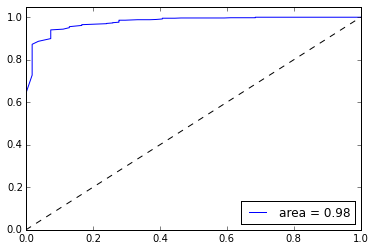

In [243]:
from performance import run_performance
run_performance(forest2, testDataVecs, y_test2)

- a Better RF model compared to RF with bag of words

### Use class weight "balanced"

In [244]:
# Fit a random forest to the training data, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest2_balanced = RandomForestClassifier( n_estimators = 100, class_weight='balanced')

print "Fitting..."
forest2_balanced = forest2_balanced.fit( trainDataVecs, y_train2)

Fitting...


Test Accuracy:  0.962637362637
Confution matrix 
[[ 28  26]
 [  8 848]]
             precision    recall  f1-score   support

   negative       0.78      0.52      0.62        54
   positive       0.97      0.99      0.98       856

avg / total       0.96      0.96      0.96       910



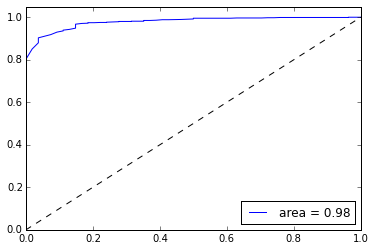

In [245]:
run_performance(forest2_balanced, testDataVecs, y_test2)

- It doesn't make difference

### SVM

In [246]:
print "Training..."
from sklearn.svm import SVC

svc2 = SVC(probability=True) 

# This may take a few minutes to run
svc2 = svc2.fit(trainDataVecs,y_train2)

Training...


Test Accuracy:  0.940659340659
Confution matrix 
[[  0  54]
 [  0 856]]
             precision    recall  f1-score   support

   negative       0.00      0.00      0.00        54
   positive       0.94      1.00      0.97       856

avg / total       0.88      0.94      0.91       910



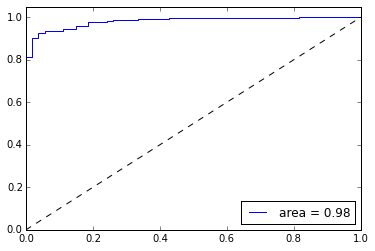

In [247]:
run_performance(svc2, testDataVecs, y_test2)

- It's not working (same as one with bag of words)

In [248]:
print "Training..."
from sklearn.svm import SVC

svc2_balanced = SVC(probability=True, class_weight='balanced') 

# This may take a few minutes to run
svc2_balanced = svc2_balanced.fit(trainDataVecs,y_train2)

Training...


Test Accuracy:  0.337362637363
Confution matrix 
[[ 54   0]
 [603 253]]
             precision    recall  f1-score   support

   negative       0.08      1.00      0.15        54
   positive       1.00      0.30      0.46       856

avg / total       0.95      0.34      0.44       910



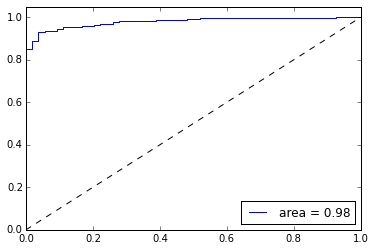

In [249]:
run_performance(svc2_balanced, testDataVecs, y_test2)

- Now with "balanced" enabled for class weights, the model is too much sensitive to detect negative sentiment. Not a good model.

## Finally, make use of the similarity of words with k-means (vector quantization)
- Word2Vec creates clusters of semantically related words
- Exploit the similarity of words within a cluster

### Create k clusters with word vectors

In [73]:
from sklearn.cluster import KMeans
import time

start = time.time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an average of 5 words per cluster. More art than science
word_vectors = model.syn0
num_clusters = word_vectors.shape[0] / 5

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print "Time taken for K Means clustering: ", elapsed, "seconds."


Time taken for K Means clustering:  69.891299963 seconds.


In [74]:
# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number                                                                                            
word_centroid_map = dict(zip( model.index2word, idx ))

### Let's see first 10 clusters

In [75]:
# first 10 clusters
for cluster in xrange(0,10):
    # Print the cluster number  
    print "\nCluster %d" % cluster
    # Find all of the words for that cluster number
    words = []
    for i in xrange(0,len(word_centroid_map.values())):
        if( word_centroid_map.values()[i] == cluster ):
            words.append(word_centroid_map.keys()[i])
    print words


Cluster 0
[u'plenty', u'lots', u'tons']

Cluster 1
[u'hide', u'lil']

Cluster 2
[u'katy']

Cluster 3
[u'labeled', u'everthing']

Cluster 4
[u'businesses']

Cluster 5
[u'caution', u'word', u'warning', u'caveat']

Cluster 6
[u'bike', u'hire', u'bikes', u'cycle', u'hired', u'riding', u'bicycles']

Cluster 7
[u'sleek', u'outfitted', u'featured', u'kitted', u'ultra', u'mod', u'luxurious', u'pristine', u'attractive']

Cluster 8
[u'effectively', u'understood', u'sorted', u'consistently']

Cluster 9
[u'elke', u'tish', u'inke', u'layne', u'jeni', u'delilah', u'andres', u'skate', u'yaffa', u'jef', u'shiloh', u'brigitte']


- Most of the grouped words make sense.

### Define a function to convert reviews into bags-of-centroids. 
- Works just like BOW but uses semantically related clusters instead of individual words

In [76]:
def create_bag_of_centroids(wordlist, word_centroid_map):
    # The number of clusters is equal to the highest cluster index in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1

    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )

    # Loop over the words in the review. If the word is in the vocabulary, find which cluster it belongs to, and increment that cluster count by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1

    # Return the "bag of centroids"
    return bag_of_centroids

In [77]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros( (len(x_train2_wl), num_clusters), \
    dtype="float32" )

# Transform the training set reviews into bags of centroids
counter = 0
for review in x_train2_wl:
    train_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

# Repeat for test reviews 
test_centroids = np.zeros(( len(x_test2_wl), num_clusters), \
    dtype="float32" )

counter = 0
for review in x_test2_wl:
    test_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

## Model with bag of centroids
### Random Forest

In [255]:
# Fit a random forest 
forest3 = RandomForestClassifier(n_estimators = 100)

print "Fitting a random forest to labeled training data..."
forest3 = forest3.fit(train_centroids,y_train2)

Fitting a random forest to labeled training data...


Test Accuracy:  0.956043956044
Confution matrix 
[[ 16  38]
 [  2 854]]
             precision    recall  f1-score   support

   negative       0.89      0.30      0.44        54
   positive       0.96      1.00      0.98       856

avg / total       0.95      0.96      0.95       910



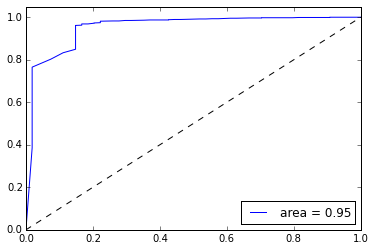

In [256]:
run_performance(forest3, test_centroids,y_test2)

### Random Forest with balanced class weight

In [292]:
forest3_balanced = RandomForestClassifier(n_estimators = 100, class_weight='balanced')

print "Fitting a random forest to labeled training data..."
forest3_balanced = forest3_balanced.fit(train_centroids,y_train2)

Fitting a random forest to labeled training data...


Test Accuracy:  0.952747252747
Confution matrix 
[[ 13  41]
 [  2 854]]
             precision    recall  f1-score   support

   negative       0.87      0.24      0.38        54
   positive       0.95      1.00      0.98       856

avg / total       0.95      0.95      0.94       910



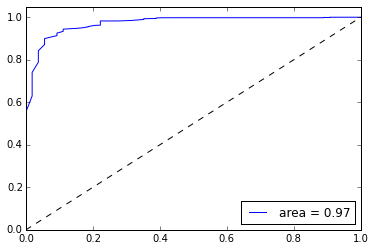

In [293]:
run_performance(forest3_balanced, test_centroids,y_test2)

- Random forest doesn't work in this case

### SVM

In [259]:
print "Training..."
from sklearn.svm import SVC

svc3 = SVC(probability=True) 

# This may take a few minutes to run
svc3 = svc3.fit(train_centroids,y_train2)

Training...


Test Accuracy:  0.953846153846
Confution matrix 
[[ 15  39]
 [  3 853]]
             precision    recall  f1-score   support

   negative       0.83      0.28      0.42        54
   positive       0.96      1.00      0.98       856

avg / total       0.95      0.95      0.94       910



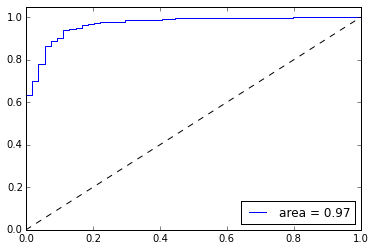

In [260]:
run_performance(svc3, test_centroids,y_test2)

- not working

### SVM with balanced class weight

In [54]:
print "Training..."
from sklearn.svm import SVC

svc3_balanced = SVC(kernel='rbf',class_weight='balanced',probability=True) 
# 'linear', 'poly', 'rbf', 'sigmoid'
# This may take a few minutes to run
svc3_balanced = svc3_balanced.fit(train_centroids,y_train2)

 Training...


Test Accuracy:  0.945054945055
Confution matrix 
[[ 59   9]
 [ 41 801]]
             precision    recall  f1-score   support

   negative       0.59      0.87      0.70        68
   positive       0.99      0.95      0.97       842

avg / total       0.96      0.95      0.95       910



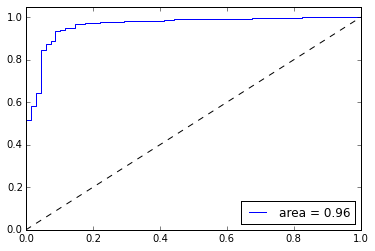

In [56]:
from performance import run_performance
run_performance(svc3_balanced, test_centroids,y_test2)

- This model is better.

## Model selection
- I tried various models and the best model that I found was stochastic gradient descent
- I'll put useful learning materials below as a refernce 

__Linear Models with L2 Regularization case__
- Gradient Descent vs Stochastic Gradient Descent (Source: Andrew Ng by Coursera)
<img src="data/gradient_descent.png" alt="" style="width: 600px;"/>  
- For GD, you have to run through ALL the samples in your training set to do a single update for a parameter in a particular iteration
- For SGD, on the other hand, you use ONLY ONE training sample from your training set to do the update for a parameter in a particular iteration.



- Hinge loss: Support Vector Machines 
<img src="data/sgd_hinge.png" alt="" style="width: 200px;"/>  
- Log loss: Logitstic regression 
<img src="data/sgd_log.png" alt="" style="width: 200px;"/>  
Source: Stochastic Gradient Descent Tricks by Microsoft Research

In [78]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

In [117]:
print "Training..."

sgb =SGDClassifier()
sgb = sgb.fit(train_centroids,y_train2)

Training...


In [118]:
run_performance(sgb, test_centroids,y_test2)

Test Accuracy:  0.957142857143
Confution matrix 
[[ 36  19]
 [ 20 835]]
             precision    recall  f1-score   support

   negative       0.64      0.65      0.65        55
   positive       0.98      0.98      0.98       855

avg / total       0.96      0.96      0.96       910



AttributeError: probability estimates are not available for loss='hinge'

- The reason for the error: to plot ROC, you can't use 'hinge' for loss. 
- This model detects negative sentiment pretty well compared to other models.

## Iterate finding/tuning a best model 

- Grid search
- Cross validation

In [50]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
from sklearn.cross_validation import StratifiedShuffleSplit

%matplotlib inline

In [48]:
len(train_centroids),len(y_train2)

(3638, 3638)

### SVM with balanced class weights

In [59]:
# SVC grid search
svc_grid = {
    'kernel': ['linear','rbf'], 
                     'gamma': [1e-2,1e-3,1e-4,1e-5],
                     'C': [1, 10, 100, 1000],
                      'class_weight': ['balanced'],}

svc_gridsearch = GridSearchCV(SVC(probability=True),
                             svc_grid,
                             verbose=True,
                             scoring='accuracy')

svc_gridsearch.fit(train_centroids,y_train2)

print "best parameters:", svc_gridsearch.best_params_

best_svc_model = svc_gridsearch.best_estimator_

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 12.4min
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 18.5min finished


Fitting 3 folds for each of 32 candidates, totalling 96 fits
best parameters: {'kernel': 'rbf', 'C': 10, 'gamma': 0.01, 'class_weight': 'balanced'}


In [60]:
# Comparison
print "New accuracy:", (cross_val_score(best_svc_model,test_centroids,y_test2, cv=5,
                        scoring='accuracy') ).mean()

print "Original accuracy:", (cross_val_score(svc3_balanced, test_centroids, y_test2, 
                    cv=5, scoring='accuracy')).mean()

New accuracy: 0.954925845823
Original accuracy: 0.953814868524


Test Accuracy:  0.948351648352
Confution matrix 
[[ 40  28]
 [ 19 823]]
             precision    recall  f1-score   support

   negative       0.68      0.59      0.63        68
   positive       0.97      0.98      0.97       842

avg / total       0.95      0.95      0.95       910



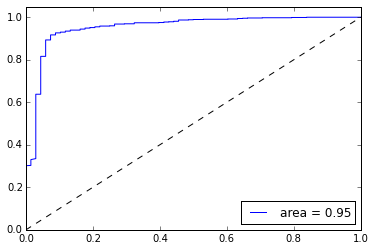

In [61]:
run_performance(best_svc_model, test_centroids,y_test2)

- Slightly better performacne but no better than standard SGD.

### SGD

In [515]:
# SGD grid search
sgd_grid = {
    'loss': ['hinge', 'log', 'modified_huber','squared_hinge'], 
    'penalty': ['l2', 'l1','elasticnet'], 
    'alpha': [1e-3,1e-4,1e-5],

    'n_iter': [5,10,20],
    'class_weight': ['balanced', None],
    'warm_start':[False, True],
    'shuffle':[True]
    }

sgd_gridsearch = GridSearchCV(SGDClassifier(),
                             sgd_grid,
                             verbose=True,
                             scoring='accuracy')

sgd_gridsearch.fit(train_centroids,y_train2)

print "best parameters:", sgd_gridsearch.best_params_

best_sgb_model = sgd_gridsearch.best_estimator_

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   28.3s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:  3.2min finished


Fitting 3 folds for each of 432 candidates, totalling 1296 fits
best parameters: {'warm_start': False, 'n_iter': 20, 'shuffle': True, 'loss': 'log', 'penalty': 'elasticnet', 'alpha': 0.001, 'class_weight': None}


In [528]:
# Comparison
print "New accuracy:", (cross_val_score(best_sgb_model,test_centroids,y_test2, cv=20,
                        scoring='accuracy') ).mean()

print "Original accuracy:", (cross_val_score(sgb, test_centroids, y_test2, 
                    cv=20, scoring='accuracy')).mean()

New accuracy: 0.950545674133
Original accuracy: 0.954917654809


Test Accuracy:  0.967032967033
Confution matrix 
[[ 38  16]
 [ 14 842]]
             precision    recall  f1-score   support

   negative       0.73      0.70      0.72        54
   positive       0.98      0.98      0.98       856

avg / total       0.97      0.97      0.97       910



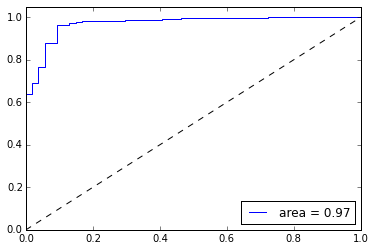

In [527]:
run_performance(best_sgb_model, test_centroids,y_test2)

- This is not a bad model but unoptimized SGD is better (in terms of capturing negative reviews) 
- The problem with unoptimized SGD is that the model is unstable. 

### a possible solution: Try bagging SGD to increase the stability.

In [103]:
print "Training..."

bagging_sgd = BaggingClassifier(base_estimator=SGDClassifier())
bagging_sgd = bagging_sgd.fit(train_centroids,y_train2)

Training...


Test Accuracy:  0.964835164835
Confution matrix 
[[ 38  17]
 [ 15 840]]
             precision    recall  f1-score   support

   negative       0.72      0.69      0.70        55
   positive       0.98      0.98      0.98       855

avg / total       0.96      0.96      0.96       910



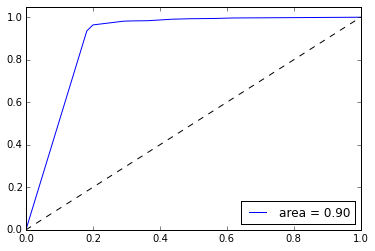

In [104]:
run_performance(bagging_sgd, test_centroids,y_test2)

- This is better. Let's tune.

In [582]:
# SGD grid search
bagging_sgd_grid = {
    'base_estimator': [SGDClassifier()], 
    'n_estimators': [10,25,50], 
    'max_samples': [1,5,10],
    'max_features': [1,5,10],
    'warm_start': [False, True],
    'random_state':[None, True],
    }


bagging_sgd_gridsearch = GridSearchCV(BaggingClassifier(),
                             bagging_sgd_grid,
                             verbose=True,
                             scoring='accuracy')

bagging_sgd_gridsearch.fit(train_centroids,y_train2)

print "best parameters:", bagging_sgd_gridsearch.best_params_

best_bagging_sgb_model = bagging_sgd_gridsearch.best_estimator_

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   31.1s


Fitting 3 folds for each of 108 candidates, totalling 324 fits
best parameters: {'warm_start': False, 'max_samples': 1, 'base_estimator': SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False), 'n_estimators': 10, 'random_state': None, 'max_features': 1}


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   56.4s finished


In [584]:
# Comparison
print "New accuracy:", (cross_val_score(best_bagging_sgb_model,test_centroids,y_test2, cv=20,
                        scoring='accuracy') ).mean()

print "Original accuracy:", (cross_val_score(bagging_sgd, test_centroids, y_test2, 
                    cv=20, scoring='accuracy')).mean()

New accuracy: 0.940812472552
Original accuracy: 0.961488801054


Test Accuracy:  0.940659340659
Confution matrix 
[[  0  54]
 [  0 856]]
             precision    recall  f1-score   support

   negative       0.00      0.00      0.00        54
   positive       0.94      1.00      0.97       856

avg / total       0.88      0.94      0.91       910



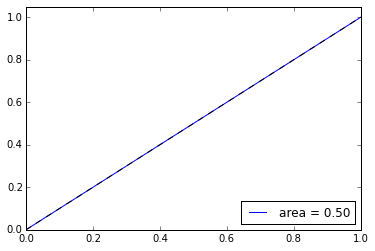

In [583]:
run_performance(best_bagging_sgb_model, test_centroids,y_test2)

- Okay.. not working. Let's stop exploring here and use the best model we got so far, Bagging SGD. 

## Check with eyes 
- Let's see if reviews are correctly separated (with human eyes)

### Test data

In [589]:
pred_index_list = []
for index, item in enumerate(bagging_sgd.predict(test_centroids)):
    if item == -1:
        pred_index_list.append(index)
    
print pred_index_list, len(pred_index_list)

[18, 38, 62, 76, 81, 136, 163, 183, 192, 195, 203, 205, 238, 243, 272, 295, 342, 345, 361, 379, 395, 400, 404, 406, 418, 429, 444, 447, 455, 457, 464, 471, 488, 501, 509, 527, 554, 563, 581, 596, 605, 618, 658, 706, 715, 748, 765, 774, 780, 784, 788, 823, 828, 834, 849, 873, 893, 901, 905] 59


In [590]:
true_index_list = []
for index, item in enumerate(y_test2):
    if item == -1:
        true_index_list.append(index)

print true_index_list, len(true_index_list)

[18, 38, 62, 76, 81, 88, 163, 192, 195, 203, 205, 211, 238, 243, 272, 316, 342, 345, 359, 361, 379, 400, 404, 418, 429, 444, 447, 455, 457, 459, 464, 471, 501, 507, 509, 527, 529, 554, 581, 596, 618, 658, 689, 706, 715, 744, 748, 769, 774, 788, 802, 834, 893, 901] 54


- with bagging SGD, it predicts 59 negative reviews for test data while the number of true negative reviews are 54. 

### Let's print the reviews

print filter(lambda x: x in true_index_list, pred_index_list), len(filter(lambda x: x in true_index_list, pred_index_list))

### Unlabeled data

In [592]:
check_no_label_list = []
for index, item in enumerate(bagging_sgd.predict(no_label_centroids[:1000])):
    if item == -1:
        check_no_label_list.append(index)
    
print check_no_label_list, len(check_no_label_list)

[339, 349, 804, 821, 824, 826, 842, 849, 866] 9


In [593]:
for index in check_no_label_list:
    sentence = " ".join(no_label_list2_wl[index])
    print sentence
    print

opal kind open hearted host unfortunately house heated especially bathroom couldn even take shower fear turning popsicle morning night could see view room main reason picked place bed gave musty fume made difficult u sleep weird picture thing looking didn help opal seemed like nice person suck write bad review re looking clean comfortable place rest head

rented gypsy room night march great stay around even live sf place rented via airbnb easy relaxed vibe social re type also meditative private prefer frankly big draw sauna floatation tank used one cost hour relaxed blissed time left hope go back soon two thumb

actually complete stay scott upon arrival unable get door unlocked despite letting scott know arriving unavailable phone text email airbnb app hour waiting outside finally neighbor let u property uncomfortable lock situation nervous leave since didn know would make back house decided book hotel room instead understand lock since replaced assume won problem future

arrived hour 

- It seems like the model is pretty good at capturing negative reviews

# Label the data
- Label all reviews with the bagging SGD model.

In [599]:
len(no_label_centroids), len(no_label_list2_wl), len(no_label_df2)

(127784, 127784, 127784)

In [602]:
bagging_sgd.predict(no_label_centroids[:10])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [600]:
no_label_df2['bagging_sgd_sentiment'] = 'no_data'

/Users/kimitakanakazawa/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [603]:
no_label_df2.bagging_sgd_sentiment = bagging_sgd.predict(no_label_centroids)

/Users/kimitakanakazawa/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [621]:
Counter(no_label_df2.bagging_sgd_sentiment)

Counter({-1.0: 1364, 1.0: 126420})

## Merge pos/neg/non_label DFs together and export in csv
- use labels if alchemy_api already labels the review
- if not, use the labels from the bagging SGD model.

In [628]:
pos_df2['bagging_sgd_sentiment'] = 1
pos_df2.head()

/Users/kimitakanakazawa/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,review_id,review_scores_rating,comments,Sentiment,alchemy_sentiment,alchemy_sentiment_score,bagging_sgd_sentiment
0,10612780,92,"[[great, host], [provided, special, gift, bask...",1,1,0.692647,1
1,49925683,92,"[[great, host], [met, me, at, apartment], [pla...",1,1,0.646267,1
2,50537634,92,"[[syeda, hosted, my, parents, for, four, days,...",No_label,1,0.656386,1
3,51077613,92,"[[i, had, a, great, experience, at, syeda, s, ...",1,1,0.817832,1
4,52109034,92,"[[great, location], [warm, welcoming, host], [...",No_label,1,0.845319,1


In [632]:
neg_df2['bagging_sgd_sentiment'] = -1
neg_df2.head()

/Users/kimitakanakazawa/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,review_id,review_scores_rating,comments,Sentiment,alchemy_sentiment,alchemy_sentiment_score,bagging_sgd_sentiment
33,45319850,99,"[[this, is, such, great, spot], [i, come, to, ...",No_label,-1,-0.0612885,-1
294,51305545,87,"[[smooth, experience], [no, real, hiccups, at,...",No_label,-1,-0.173146,-1
465,36558097,97,"[[michelle, s, space, had, lots, of, room, and...",No_label,-1,-0.13192,-1
600,1710314,97,"[[we, enjoyed, our, stay, at, this, place, it,...",No_label,-1,-0.0892277,-1
731,43799775,98,"[[i, do, not, understand, why, is, this, place...",No_label,-1,-0.240224,-1


In [633]:
frames = [pos_df2, neg_df2, no_label_df2]
df3 = pd.concat(frames)
df3.head()

,review_id,review_scores_rating,comments,Sentiment,alchemy_sentiment,alchemy_sentiment_score,bagging_sgd_sentiment
0,10612780,92,"[[great, host], [provided, special, gift, bask...",1,1,0.692647,1
1,49925683,92,"[[great, host], [met, me, at, apartment], [pla...",1,1,0.646267,1
2,50537634,92,"[[syeda, hosted, my, parents, for, four, days,...",No_label,1,0.656386,1
3,51077613,92,"[[i, had, a, great, experience, at, syeda, s, ...",1,1,0.817832,1
4,52109034,92,"[[great, location], [warm, welcoming, host], [...",No_label,1,0.845319,1


In [634]:
Counter(df3.bagging_sgd_sentiment)

Counter({-1.0: 1649, 1.0: 130683})

In [652]:
df3 = df3[['review_id','bagging_sgd_sentiment']]
# df3.head()
df3.to_csv('data/df_new_en_labeled_bagging_sgd_sentiment.csv')

In [649]:
check_unique = 0
for key, value in enumerate(Counter(df3.review_id).items()):
    if value[1] > 1:
        check_unique +=1
check_unique

0